<h1> Rossmann data clean</h1>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.basics import *

In [0]:
PATH = Path('/content/drive/My Drive/rossmann')

In [5]:
# PATH=Config().data_path()/Path('rossmann/')
table_names = ['train', 'store', 'store_states', 'state_names', 'googletrend', 'weather', 'test']
tables = [pd.read_csv(PATH/f'{fname}.csv', low_memory=False) for fname in table_names]
train, store, store_states, state_names, googletrend, weather, test = tables
len(train),len(test)

(1017209, 41088)

In [0]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [0]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))


In [0]:
weather = join_df(weather, state_names, "file", "StateName")

In [0]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [0]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

In [0]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [20]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [21]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [22]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [23]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [24]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [0]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [0]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [0]:

for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

In [29]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()


array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

In [0]:
! pip install isoweek

In [0]:
from isoweek import Week
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [0]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [0]:
joined.to_pickle(PATH/'joined')
joined_test.to_pickle(PATH/'joined_test')

In [0]:

def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [0]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [0]:

#df = train[columns]
df = train[columns].append(test[columns])

In [0]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:

fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [0]:
df = df.set_index("Date")

In [0]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [0]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [0]:

bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [0]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()


In [0]:

bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [0]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [0]:
df.reset_index(inplace=True)

In [0]:

df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [0]:
df.drop(columns,1,inplace=True)

In [52]:

df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


In [0]:
df.to_pickle(PATH/'df')


In [0]:
df["Date"] = pd.to_datetime(df.Date)

In [55]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [0]:

joined = pd.read_pickle(PATH/'joined')
joined_test = pd.read_pickle(PATH/f'joined_test')

In [0]:

joined = join_df(joined, df, ['Store', 'Date'])

In [0]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [0]:
joined = joined[joined.Sales!=0]

In [0]:

joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [0]:
joined.to_pickle(PATH/'train_clean')
joined_test.to_pickle(PATH/'test_clean')

<h1>Rossman data modelling</h1>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

In [0]:
path = Path('/content/drive/My Drive/rossmann')

In [0]:
train_df = pd.read_pickle(path/'train_clean')


In [68]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [69]:
n = len(train_df); n

844338

In [0]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [71]:
len(train_df),len(test_df)

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [0]:
test_df['Date'].min(), test_df['Date'].max()

In [75]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [0]:
valid_idx = range(cut)

In [77]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

<h1>Model</h1>

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [81]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [82]:
len(data.train_ds.cont_names)

16

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


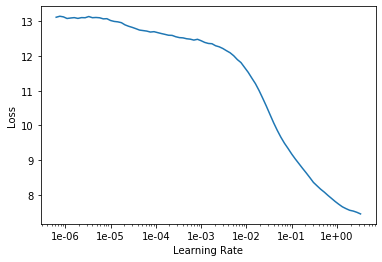

In [84]:
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.026537,0.023782,0.165931,02:47
1,0.018469,0.020437,0.145125,02:47
2,0.016252,0.017893,0.121481,02:47
3,0.012709,0.013539,0.109200,02:44
4,0.010292,0.011697,0.105421,02:42


In [0]:
learn.save('1')

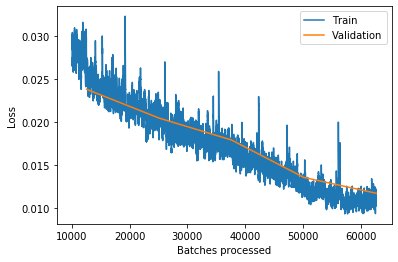

In [87]:
learn.recorder.plot_losses(skip_start=10000)

In [0]:
learn.load('1');

In [89]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.013077,0.012883,0.109420,02:42
1,0.013516,0.012945,0.116219,02:42
2,0.010610,0.015944,0.110077,02:42
3,0.010605,0.014229,0.111992,02:40
4,0.009720,0.014009,0.115324,02:40


In [90]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010775,0.013991,0.113643,02:41
1,0.012234,0.019613,0.163140,02:40
2,0.009829,0.017805,0.134836,02:38
3,0.009163,0.019222,0.118451,02:39
4,0.010873,0.017363,0.132418,02:38


In [91]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

(10th place in the competition was 0.108)